### Load Packages and Data

In [1]:
import optuna as opt

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from functools import partial
from sklearn import linear_model
import sklearn.metrics 
from scipy import optimize

In [3]:
data = pd.read_csv("C:/Users/nfole/OneDrive/Desktop/automated_mmm/data/final_data.csv", parse_dates = ["DATE"])

### Adstock And Saturation Functions

#### Adstock 
* Geometric adstock
* Formula= X[xi] + adstock rate * x_decayed[xi - 1]
* Description = Current Period X + adstock rate * x previous period

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
class AdstockGeometric(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.5):
        self.alpha = alpha
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: np.ndarray):
        x_decayed = np.zeros_like(X)
        x_decayed[0] = X[0]
        
        for xi in range(1, len(x_decayed)):
            x_decayed[xi] = X[xi] + self.alpha * x_decayed[xi - 1]
        return x_decayed

#### Saturation
* Hill Transformation
* Formula= (1 + midpoint**slope_s / (X**slope_s +  epsilon))**-1
* Description = 1 + midpoint^slope / (X^slope + epsilon))^-1
* epsilon is a constant to ensure not 0

In [5]:
class HillSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, slope_s, half_saturation_k):
        if slope_s < 0 or half_saturation_k < 0:
            raise ValueError("slope_s and half_saturation_k must be non-negative")
                             
        self.slope_s = slope_s
        self.half_saturation_k = half_saturation_k
        self.epsilon = 1e-9  # small constant value to avoid division by zero
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: np.ndarray, x_point = None):
        
        self.half_saturation_k_transformed  = self.half_saturation_k * (np.max(X) - np.min(X)) + np.min(X)
        
        if x_point is None:
            return (1 + self.half_saturation_k_transformed**self.slope_s / (X**self.slope_s + self.epsilon))**-1
        
        #calculate y at x_point
        return (1 + self.half_saturation_k_transformed**self.slope_s / (x_point**self.slope_s + self.epsilon))**-1
            

#### Specify Features and parameters

In [6]:
target = "revenue"
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
control_features = ["trend", "season",  "competitor_sales_B"]
features = control_features + media_channels 

Parameters are the minmimum and maximum possible values for the trial runs

In [7]:
adstock_features_params = {
    "tv_S_adstock": (0.3, 0.8),
    "ooh_S_adstock": (0.1, 0.4),
    "print_S_adstock": (0.1, 0.4),
    "facebook_S_adstock": (0.1, 0.4),
    "search_S_adstock": (0.1, 0.4)}
hill_slopes_params = {
    "tv_S_hill_slope": (0.1, 5.0),
    "ooh_S_hill_slope": (0.1, 5.0),
    "print_S_hill_slope": (0.1, 5.0),
    "facebook_S_hill_slope": (0.1, 5.0),
    "search_S_hill_slope": (0.1, 5.0)}
hill_half_saturations_params = {
    "tv_S_hill_half_saturation": (0.1, 1.0),
    "ooh_S_hill_half_saturation": (0.1, 1.0),
    "print_S_hill_half_saturation": (0.1, 1.0),
    "facebook_S_hill_half_saturation": (0.1, 1.0),
    "search_S_hill_half_saturation": (0.1, 1.0)}


#### Individual Trial Function
* Run a trial using suggested values for adstock rate, slope, and midpoint between the minimum and maximum parameter values

In [8]:
def optuna_trial(trial, 
                 data:pd.DataFrame, 
                 target, 
                 features, 
                 adstock_features, 
                 adstock_features_params, 
                 hill_slopes_params, 
                 hill_half_saturations_params, 
                 tscv):
    
    data_temp = data.copy()
    adstock_alphas = {}
    hill_slopes = {}
    hill_half_saturations = {}
    
    for feature in adstock_features:
        adstock_param = f"{feature}_adstock"
        min_, max_ = adstock_features_params[adstock_param]
        adstock_alpha = trial.suggest_float(f"adstock_alpha_{feature}", min_, max_)
        adstock_alphas[feature] = adstock_alpha
        
        hill_slope_param = f"{feature}_hill_slope"
        min_, max_ = hill_slopes_params[hill_slope_param]
        hill_slope = trial.suggest_float(f"hill_slope_{feature}", min_, max_)
        hill_slopes[feature] = hill_slope
        
        hill_half_saturation_param = f"{feature}_hill_half_saturation"
        min_, max_ = hill_half_saturations_params[hill_half_saturation_param]
        hill_half_saturation = trial.suggest_float(f"hill_half_saturation_{feature}", min_, max_)
        hill_half_saturations[feature] = hill_half_saturation
        
        
        #adstock transformation
        x_feature = data[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        
        #hill saturation transformation
        temp_hill_saturation = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(temp_adstock)
        data_temp[feature] = temp_hill_saturation
        
        
    #Ridge parameters
    ridge_alpha = trial.suggest_float("ridge_alpha", 0.01, 10000)
    scores = []
    
    #cross validation
    for train_index, test_index in tscv.split(data_temp):
        x_train = data_temp.iloc[train_index][features]
        y_train =  data_temp[target].values[train_index]
        
        x_test = data_temp.iloc[test_index][features]
        y_test = data_temp[target].values[test_index]
        
        #params of Ridge Regression
        params = {"alpha": ridge_alpha}
        
        ridge = linear_model.Ridge(alpha = ridge_alpha, random_state=0)
        ridge.fit(x_train, y_train)
        prediction = ridge.predict(x_test)
        
        rmse = 	sklearn.metrics.mean_absolute_error(y_true = y_test, y_pred = prediction)
        scores.append(rmse)
        
        
    trial.set_user_attr("scores", scores)
    
    trial.set_user_attr("params", params)
    trial.set_user_attr("adstock_alphas", adstock_alphas)
    trial.set_user_attr("hill_slopes", hill_slopes)
    trial.set_user_attr("hill_half_saturations", hill_half_saturations)
    
    
    #average of all scores    
    return np.mean(scores)

#### Run Experiment 
* Description: iterating over potential Parameters to find best model

In [9]:
def optuna_optimize(trials, 
                    data: pd.DataFrame, 
                    target, 
                    features, 
                    adstock_features, 
                    adstock_features_params, 
                    hill_slopes_params, 
                    hill_half_saturations_params, 
                    tscv, 
                    seed = 42):
    print(f"data size: {len(data)}")
    
    print(f"adstock features: {adstock_features}")
    print(f"features: {features}")

    opt.logging.set_verbosity(opt.logging.WARNING) 
    
    study_mmm = opt.create_study(direction='minimize', sampler = opt.samplers.TPESampler(seed=seed))  
        
    optimization_function = partial(optuna_trial, 
                                    data = data, 
                                    target = target, 
                                    features = features, 
                                    adstock_features = adstock_features, 
                                    adstock_features_params = adstock_features_params, 
                                    hill_slopes_params = hill_slopes_params, 
                                    hill_half_saturations_params = hill_half_saturations_params, 
                                    tscv = tscv, 
                                    )
    
    
    study_mmm.optimize(optimization_function, n_trials = trials, show_progress_bar = True)
    
    return study_mmm

In [10]:
tscv = TimeSeriesSplit(n_splits=2)

OPTUNA_TRIALS = 20
experiment = optuna_optimize(trials = OPTUNA_TRIALS, 
                             data = data, 
                             target = target, 
                             features = features, 
                             adstock_features = media_channels, 
                             adstock_features_params = adstock_features_params, 
                             hill_slopes_params = hill_slopes_params,
                             hill_half_saturations_params = hill_half_saturations_params,
                             tscv = tscv)

data size: 208
adstock features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']
features: ['trend', 'season', 'competitor_sales_B', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']


  0%|          | 0/20 [00:00<?, ?it/s]

### Model Refit
* Use the best parameters from the experiment to use the optimal adstock rate, slope, and midpoint for adstock and saturation

In [11]:
# Get Best Parameters
best_params = experiment.best_trial.user_attrs["params"]
adstock_params_best = experiment.best_trial.user_attrs["adstock_alphas"]
hill_slopes_params_best = experiment.best_trial.user_attrs["hill_slopes"]
hill_half_saturations_params_best = experiment.best_trial.user_attrs["hill_half_saturations"]

#### Refit Model
* Description: Refit the model using the best parameters to calculate adstock advertising

In [12]:
def model_refit(data, 
                target, 
                features, 
                media_channels, 
                model_params, 
                adstock_params, 
                hill_slopes_params,
                hill_half_saturations_params,
                start_index, 
                end_index):
    data_refit = data.copy()

    best_params = model_params

    adstock_alphas = adstock_params


    #apply adstock transformation

    temporal_features = [feature if feature not in media_channels  else f"{feature}_hill" for feature in features]

    for feature in media_channels :
        adstock_alpha = adstock_alphas[feature]
        print(f"applying geometric adstock transformation on {feature} with alpha {adstock_alpha:0.3}") 

        #adstock transformation
        x_feature = data_refit[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)

        hill_slope = hill_slopes_params[feature]
        hill_half_saturation = hill_half_saturations_params[feature]
        print(f"applying saturation hill transformation on {feature} with saturation slope {hill_slope:0.3} and half saturation {hill_half_saturation:0.3}")

        temp_hill_saturation = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(temp_adstock)
        data_refit[f"{feature}_adstock"] = temp_adstock
        data_refit[f"{feature}_hill"] = temp_hill_saturation

    #build the final model on the data until the end analysis index
    x_input = data_refit.iloc[:end_index][temporal_features].copy()
    y_true_all = data[target].values[:end_index]

    #build ridge using the best parameters
    model = linear_model.Ridge(random_state=0, **best_params)
    model.fit(x_input, y_true_all) 


    #concentrate on the analysis interval
    y_true_interval = y_true_all[start_index:end_index]
    #transformed data
    x_input_interval_transformed = x_input.iloc[start_index:end_index]

    #revenue prediction for the analysis interval
    print(f"predicting {len(x_input_interval_transformed)} instances")
    prediction = model.predict(x_input_interval_transformed)

    #non transformed data set for the analysis interval 
    x_input_interval_nontransformed = data.iloc[start_index:end_index]


    return {
            'x_input_interval_nontransformed': x_input_interval_nontransformed, 
            'x_input_interval_transformed' : x_input_interval_transformed,
            'prediction_interval': prediction, 
            'y_true_interval': y_true_interval,
            "model": model,
            "model_train_data": x_input,
            "model_data": data_refit, 
            "model_features": temporal_features, 
            "features": features
           }
    

In [13]:
# Run Best Model using optimized parameters
result = model_refit(data = data, 
                     target = target,
                     features = features, 
                     media_channels = media_channels, 
                     model_params = best_params, 
                     adstock_params = adstock_params_best, 
                     hill_slopes_params=hill_slopes_params_best,
                     hill_half_saturations_params=hill_half_saturations_params_best,
                     start_index = 0, 
                     end_index = data.shape[0])

applying geometric adstock transformation on tv_S with alpha 0.658
applying saturation hill transformation on tv_S with saturation slope 1.67 and half saturation 0.26
applying geometric adstock transformation on ooh_S with alpha 0.4
applying saturation hill transformation on ooh_S with saturation slope 2.78 and half saturation 0.785
applying geometric adstock transformation on print_S with alpha 0.238
applying saturation hill transformation on print_S with saturation slope 0.115 and half saturation 0.392
applying geometric adstock transformation on facebook_S with alpha 0.392
applying saturation hill transformation on facebook_S with saturation slope 3.28 and half saturation 0.493
applying geometric adstock transformation on search_S with alpha 0.236
applying saturation hill transformation on search_S with saturation slope 4.93 and half saturation 0.119
predicting 208 instances


#### Calculate Accuracy Metrics and plot Predicted vs Actuals

In [14]:
rmse_metric = mean_squared_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"], squared=False)
mape_metric = mean_absolute_percentage_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])


print(f'RMSE: {rmse_metric}')
print(f'MAPE: {mape_metric}')



fig, ax = plt.subplots(figsize = (25, 8))
_ = ax.plot(result["prediction_interval"], color = "blue", label = "predicted")
_ = ax.plot(result["y_true_interval"], 'ro', label = "true")
_ = plt.title(f"RMSE: {np.round(rmse_metric)}, MAPE: {np.round(mape_metric, 3)}")
_ = ax.legend()

NameError: name 'mean_squared_error' is not defined

#### Get The Underlying Model Data and coefficients

In [15]:
#shows the callable objects from the result dataframe of the optimized model
result.keys()
#save feature coefficients 
feature_coefficients = {}
for feature, model_feature, coef in zip(result["features"], result["model_features"], result["model"].coef_):
    feature_coefficients[feature] = coef
    print(f"feature: {feature} -> coefficient {coef}")
#data used for modeling
result["model_data"].head()

feature: trend -> coefficient 3.4696545893190587
feature: season -> coefficient 0.4476387782864782
feature: competitor_sales_B -> coefficient 0.17276254785130765
feature: tv_S -> coefficient 74337.84413987651
feature: ooh_S -> coefficient 4661.625691554027
feature: print_S -> coefficient 11166.458115462061
feature: facebook_S -> coefficient 40671.6626109753
feature: search_S -> coefficient -7811.366402723341


,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,...,tv_S_adstock,tv_S_hill,ooh_S_adstock,ooh_S_hill,print_S_adstock,print_S_hill,facebook_S_adstock,facebook_S_hill,search_S_adstock,search_S_hill
0,2015-11-23,2754371.667,167687.6,0,95463.66667,7.290385e+07,0.00000,0,8125009,228213.98740,...,167687.600000,0.197670,0,4.809624e-26,95463.666670,0.499589,228213.987400,0.478243,0,6.089982e-31
1,2015-11-30,2584276.667,214600.9,0,0.00000,1.658110e+07,29511.71546,31000,7901549,34258.57351,...,324858.976850,0.426864,0,4.809624e-26,22734.187528,0.458319,123768.596030,0.109622,31000,8.961055e-01
2,2015-12-07,2547386.667,0.0,248022,3404.00000,4.995477e+07,36132.35896,28400,8300197,127691.26130,...,213601.518745,0.269715,248022,4.326131e-02,8818.031333,0.431355,176235.743363,0.281895,35706,9.454076e-01
3,2015-12-14,2875220.000,625877.3,0,132600.00000,3.164930e+07,36804.21096,31900,8122883,84014.72031,...,766324.731229,0.757871,99123,3.533341e-03,134699.969391,0.509514,153137.851355,0.198451,40315,9.692456e-01
4,2015-12-21,2215953.333,0.0,520005,0.00000,8.802269e+06,28401.74407,27100,7105985,20687.47816,...,503874.413538,0.608172,559620,3.020371e-01,32078.113809,0.468191,80751.160845,0.029435,36602,9.513836e-01


#### Plot Adstocked Advertising Compared to Spend by Channel

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

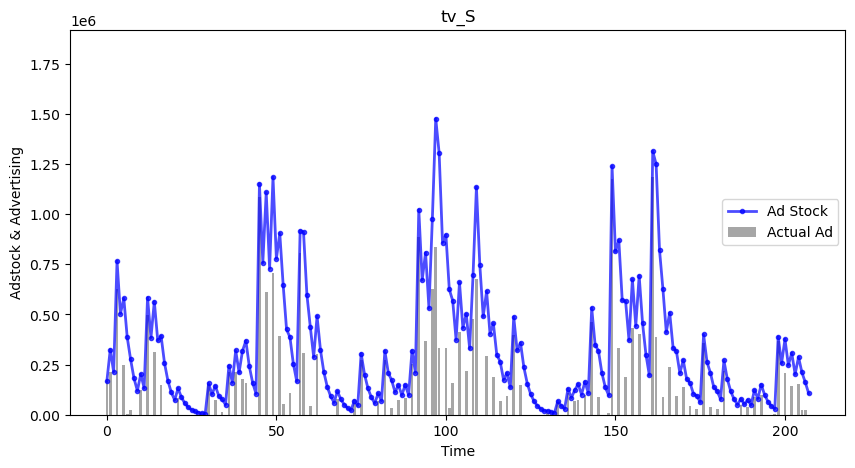

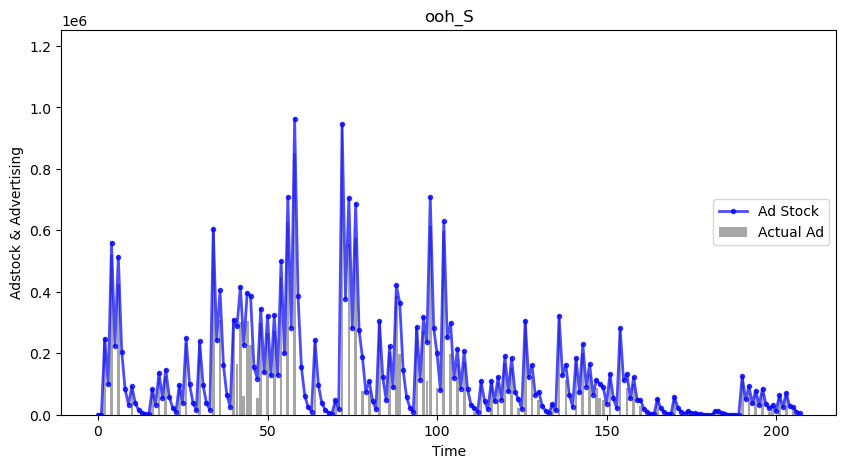

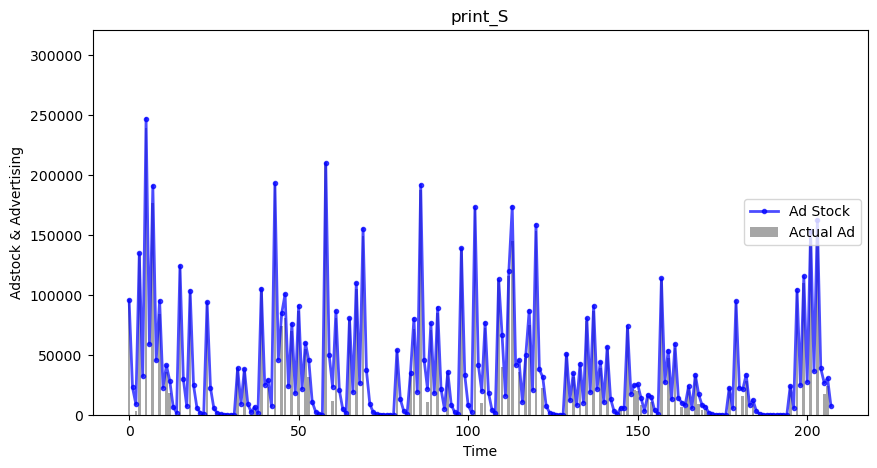

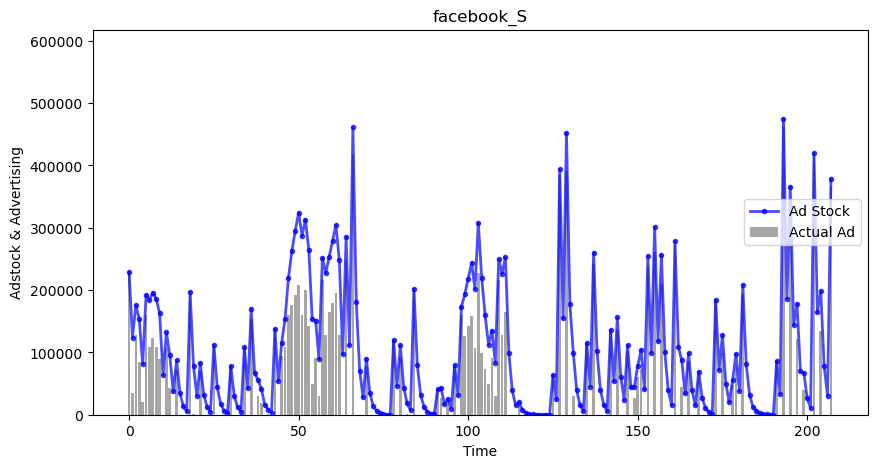

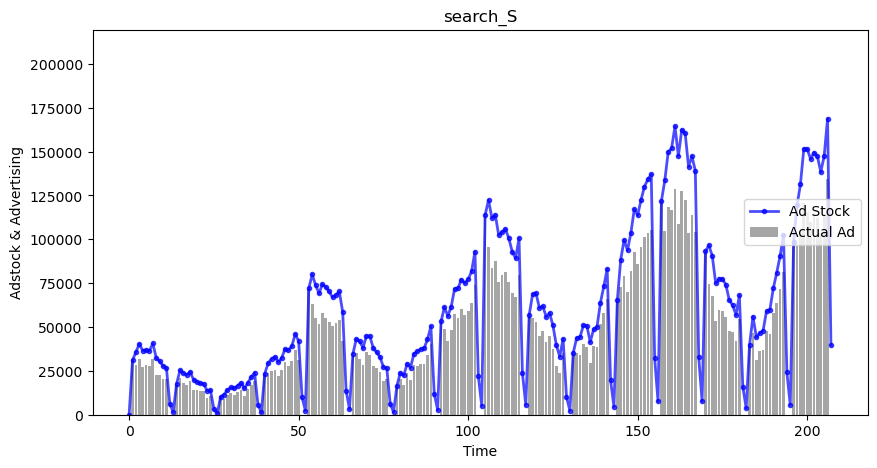

In [17]:
for feature in media_channels :
    advertising=result["model_data"][feature]
    adstocked_advertising=result["model_data"][f"{feature}_adstock"] 
    fig, ax = plt.subplots(figsize=(10,5), dpi=100)

    ax.set_ylim([0, 1.3*max(adstocked_advertising)])

    bar = ax.bar(np.arange(len(advertising)), advertising, width=0.8, color='gray', alpha=0.7, label='Actual Ad')
    line = ax.plot(np.arange(len(advertising)), adstocked_advertising, 
               marker='o', markersize=3, linestyle='-', linewidth=2, color='blue', alpha=0.7, label='Ad Stock')

    ax.set_xlabel('Time')
    ax.set_ylabel('Adstock & Advertising')
    ax.set_title(feature)


    ax.legend(loc='center right')  
plt.show()

### Generate Response Curves using Hill Saturation

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [19]:
def format_thousands_millions(x, pos) -> str:
    if abs(x) >= 1e6:
        return "{:.1f}M".format(x * 1e-6)
    elif abs(x) >= 1e3:
        return "{:.1f}K".format(x * 1e-3)
    else:
        return "{:.1f}".format(x)
    
def plot_spend_response_curve(channel, spend_response_df, average_spend=0, average_response=0, optimized_spend=None, optimized_response=None, figure_size=(15, 6)):

    average_spend_response_df = pd.DataFrame({
        'average_spend': [average_spend], 
        'average_response': [average_response]
    })

    fig, ax = plt.subplots(figsize=figure_size)
    sns.lineplot(data=spend_response_df, x='spend', y='response')
    plt.xlabel('Spend (with adstock effect)')
    plt.ylabel('Response')
    sns.scatterplot(data=average_spend_response_df, x='average_spend', y='average_response', color='blue', s=100)
    plt.axvline(x=average_spend_response_df['average_spend'][0], linestyle='dotted', alpha=0.5)
    plt.axhline(y=average_spend_response_df['average_response'][0], linestyle='dotted', alpha=0.5)

    #plt.xticks(ticks=range(0, int(max(spend_response_df["spend"])), 50_000)) 
    ax.xaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
    ax.yaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
    
    
    
    if optimized_spend is not None and optimized_response is not None:
        optimized_spend_response_df = pd.DataFrame({
            'optimized_spend': [optimized_spend], 
            'optimized_response': [optimized_response]
        })
        sns.scatterplot(data=optimized_spend_response_df, x='optimized_spend', y='optimized_response', color='green', s=150)
        plt.axvline(x=optimized_spend_response_df['optimized_spend'][0], linestyle='dotted', alpha=0.5, color='green')
        plt.axhline(y=optimized_spend_response_df['optimized_response'][0], linestyle='dotted', alpha=0.5, color='green')
        plt.title(f"{channel}: Response curve, mean and optimized spend\nAverage Spend: {average_spend}\nAverage Response: {average_response:.3f}\nOptimized Spend: {optimized_spend:.3f}\nOptimized Response: {optimized_response:.3f}")
    else:
        plt.title(f"{channel}: Response curve and mean spend\nAverage Spend: {average_spend}\nAverage Response: {average_response:.3f}")

    plt.legend()
    plt.show()


#### Get Response Curve Data and Print Indvidual Response Curves

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tv_S
	tv_S: adstock: 0.6575207519792932
	tv_S: saturation slope: 1.6728929409625368
	tv_S: half saturation k: 0.2599640747807821
	tv_S: coefficient: 74337.84413987651
	average spend: 111327, avergae non-zero spend: 251697, min spend: 0.0, max spend: 1185349.3
	average response corresponding to the average spending including weeks of no-spend: 24312.75895533733


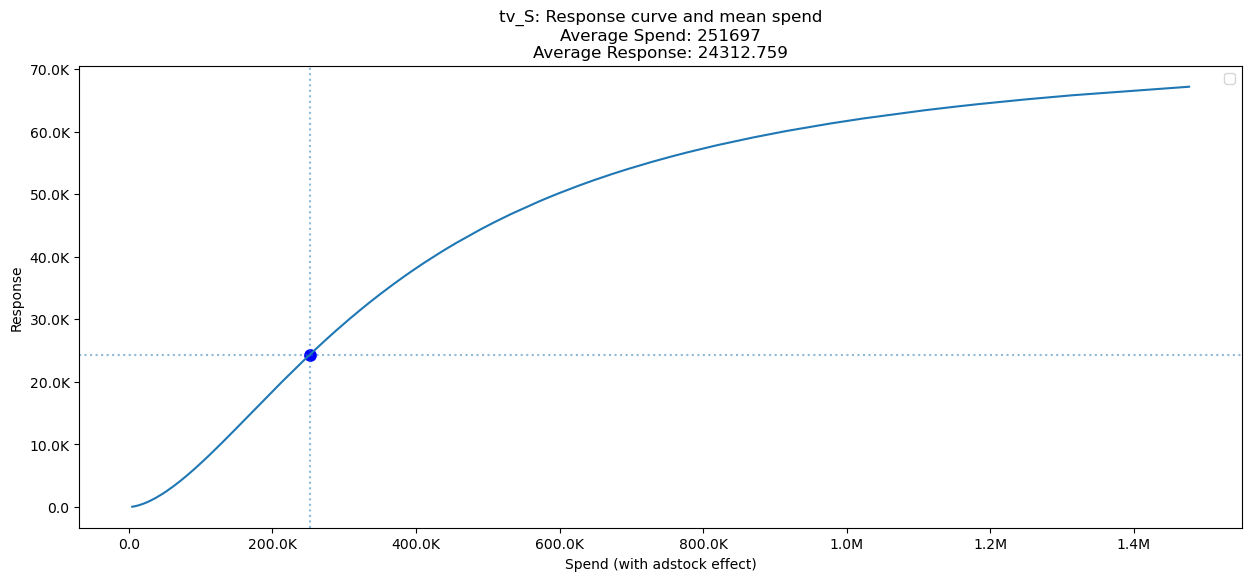

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
ooh_S
	ooh_S: adstock: 0.3996557053973208
	ooh_S: saturation slope: 2.7756460150924323
	ooh_S: half saturation k: 0.7852233074870995
	ooh_S: coefficient: 4661.625691554027
	average spend: 81033, avergae non-zero spend: 198294, min spend: 0, max spend: 938178
	average response corresponding to the average spending including weeks of no-spend: 110.58047676811091


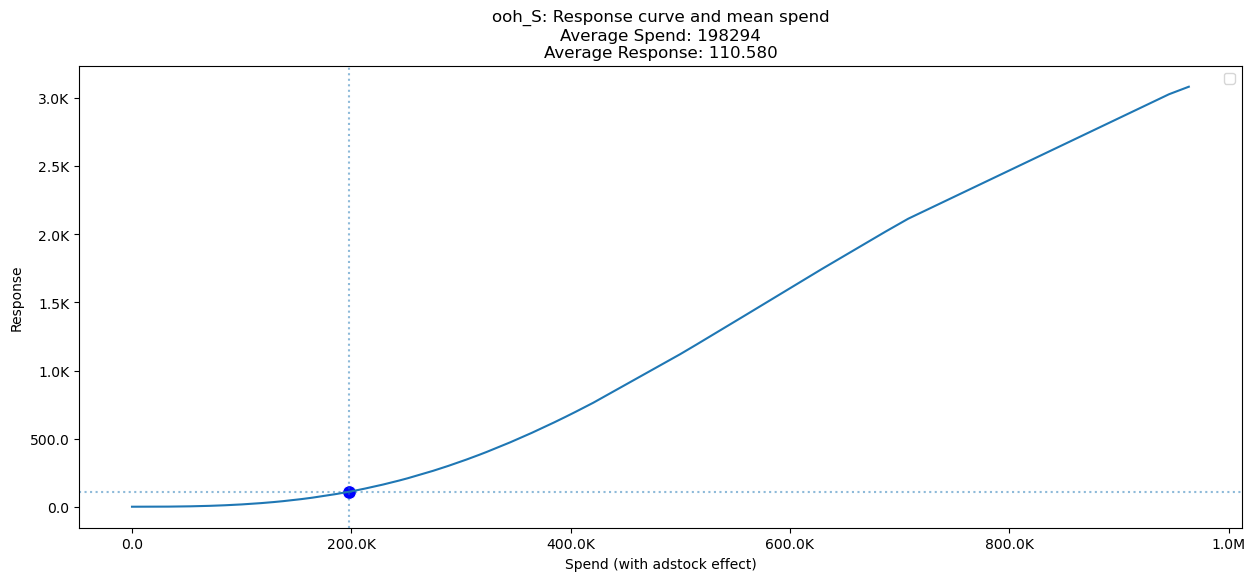

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
print_S
	print_S: adstock: 0.23814492278162178
	print_S: saturation slope: 0.11531762025615766
	print_S: half saturation k: 0.3919568318352354
	print_S: coefficient: 11166.458115462061
	average spend: 27964, avergae non-zero spend: 66858, min spend: 0.0, max spend: 239417.3333
	average response corresponding to the average spending including weeks of no-spend: 5463.993356036644


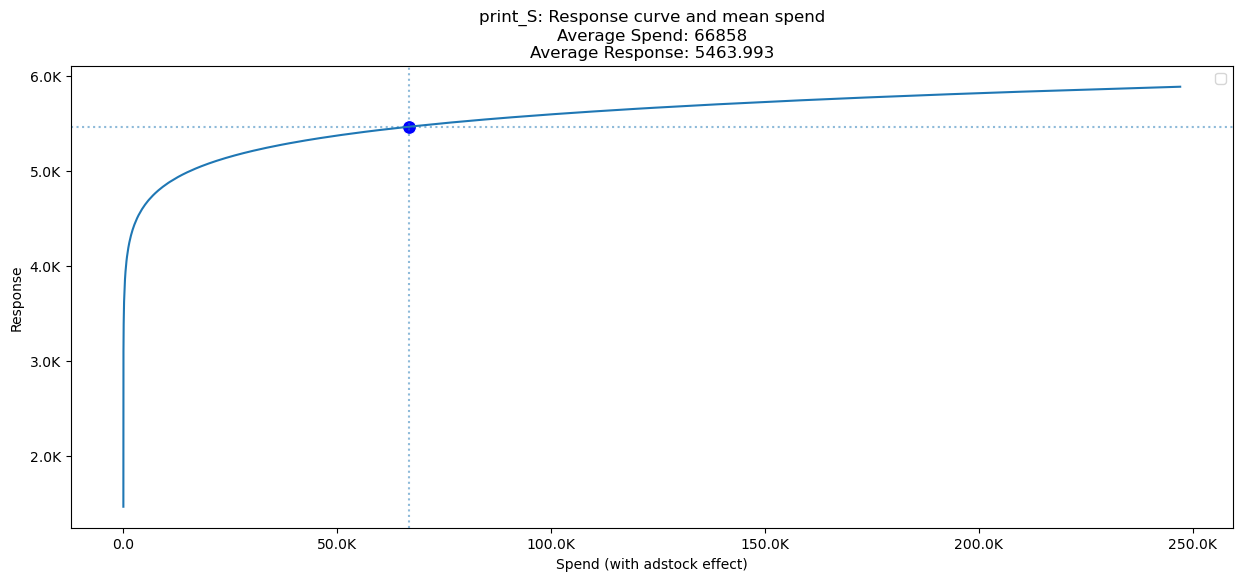

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
facebook_S
	facebook_S: adstock: 0.39221970370858683
	facebook_S: saturation slope: 3.280962284516096
	facebook_S: half saturation k: 0.4931449729532996
	facebook_S: coefficient: 40671.6626109753
	average spend: 64369, avergae non-zero spend: 132563, min spend: 0.0, max spend: 462011.7422
	average response corresponding to the average spending including weeks of no-spend: 5434.261188421096


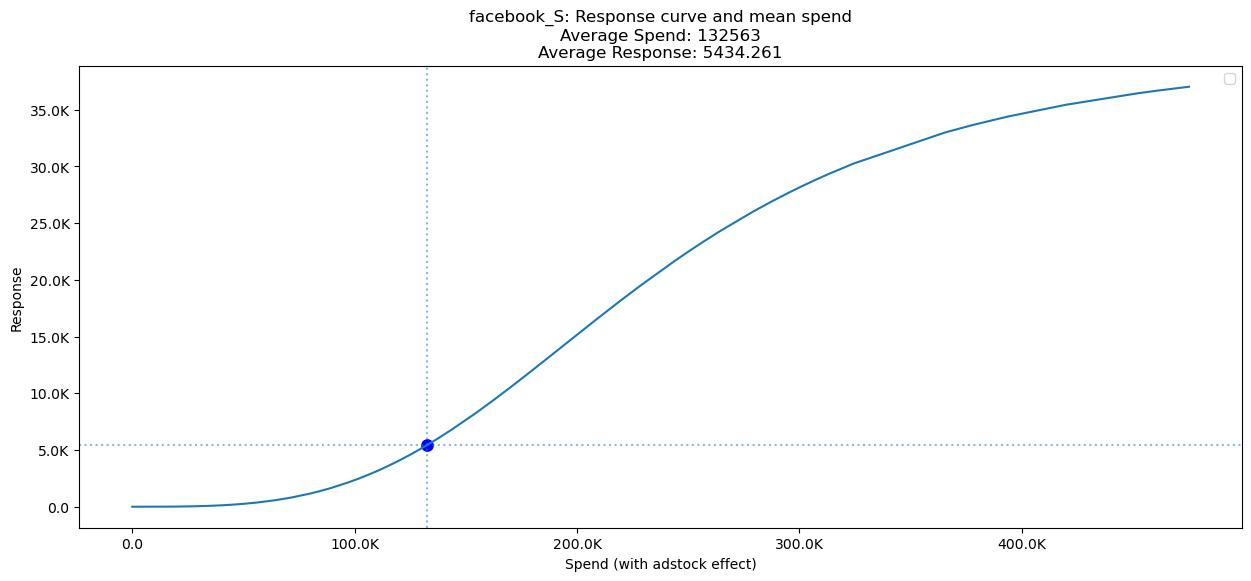

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
search_S
	search_S: adstock: 0.2356978938632826
	search_S: saturation slope: 4.931945398352253
	search_S: half saturation k: 0.11862922630461825
	search_S: coefficient: -7811.366402723341
	average spend: 44366, avergae non-zero spend: 52432, min spend: 0, max spend: 134100
	average response corresponding to the average spending including weeks of no-spend: -7744.136095704516


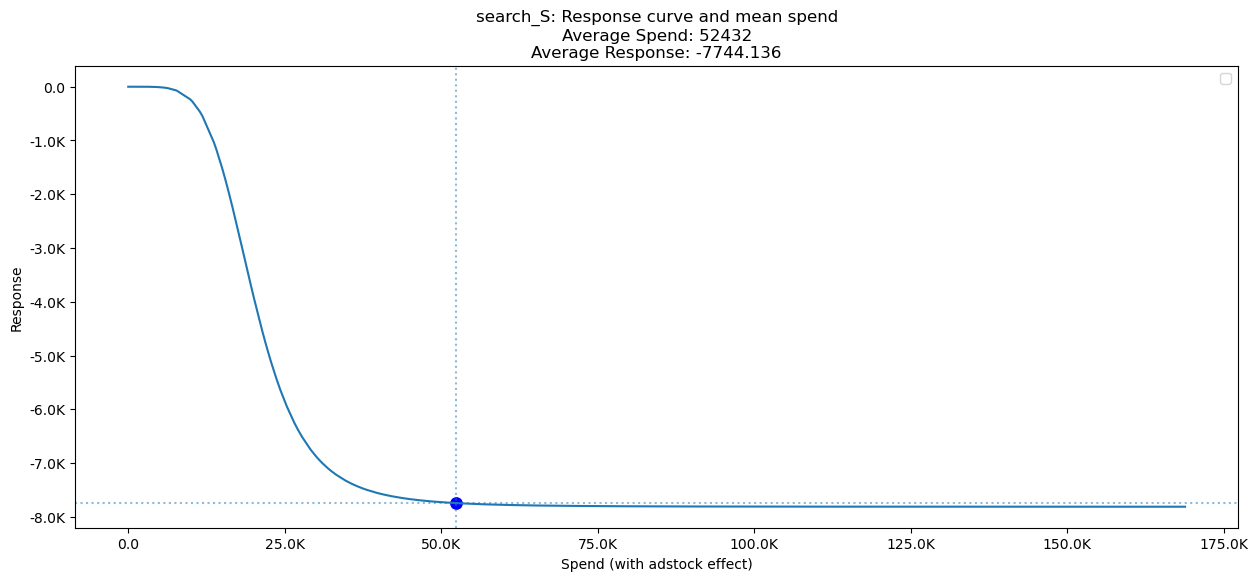

None


In [20]:
#dataframe for budget allocation
media_spend_response_data = []

#holds spend and response time series along with average spend/response for plotting spend-response curve
spend_response_curve_dict = {}

for media_channel in media_channels:
    print(media_channel)
    
    adstock = adstock_params_best[media_channel]
    print(f"\t{media_channel}: adstock: {adstock}")

    hill_slope = hill_slopes_params_best[media_channel]
    hill_half_saturation = hill_half_saturations_params_best[media_channel]
    print(f"\t{media_channel}: saturation slope: {hill_slope}")
    print(f"\t{media_channel}: half saturation k: {hill_half_saturation}")

    coef = feature_coefficients[media_channel]
    print(f"\t{media_channel}: coefficient: {coef}")
    ######################################################

    #loc returns end index inclusive
    spendings = result["model_data"][media_channel].values
    average_nonzero_spending = int(spendings[spendings > 0].mean())
    average_spending = int(spendings.mean())
    print(f"\taverage spend: {average_spending}, avergae non-zero spend: {average_nonzero_spending}, min spend: {spendings.min()}, max spend: {spendings.max()}")

    spendings_adstocked = AdstockGeometric(alpha = adstock).fit_transform(spendings)
    
    #we have to use the same data that we used for training for proper mapping of the average spending
    average_response = coef * HillSaturation(slope_s=hill_slope, half_saturation_k=hill_half_saturation).transform(X = spendings_adstocked, x_point = average_nonzero_spending)
    print(f"\taverage response corresponding to the average spending including weeks of no-spend: {average_response}")

    #numpy array returns end index exclusive
    spendings_saturated = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(spendings_adstocked)
    
    response = spendings_saturated * coef  

    spend_response_temp_df = pd.DataFrame({'spend': spendings_adstocked, 'response': response, "media_channel": media_channel})

    media_spend_response_data.append(spend_response_temp_df)
    
    plot = plot_spend_response_curve(media_channel, spend_response_temp_df, average_spend = average_nonzero_spending, average_response = average_response)
    print(plot)
    

media_spend_response_data = pd.concat(media_spend_response_data)

#### Plot All Response Curves Together

In [21]:
def plot_multiple_spend_response_curves(spend_response_df, figure_size=(15, 6)):
    fig, ax = plt.subplots(figsize=figure_size)
    sns.lineplot(data=spend_response_df, x='spend', y='response', hue='media_channel', style='media_channel')
    plt.xlabel('Spend (with adstock effect)')
    plt.ylabel('Response')
    plt.title('Response curves')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    ax.xaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
    ax.yaxis.set_major_formatter(
        mtick.FuncFormatter(format_thousands_millions)
    )
            
    plt.show()

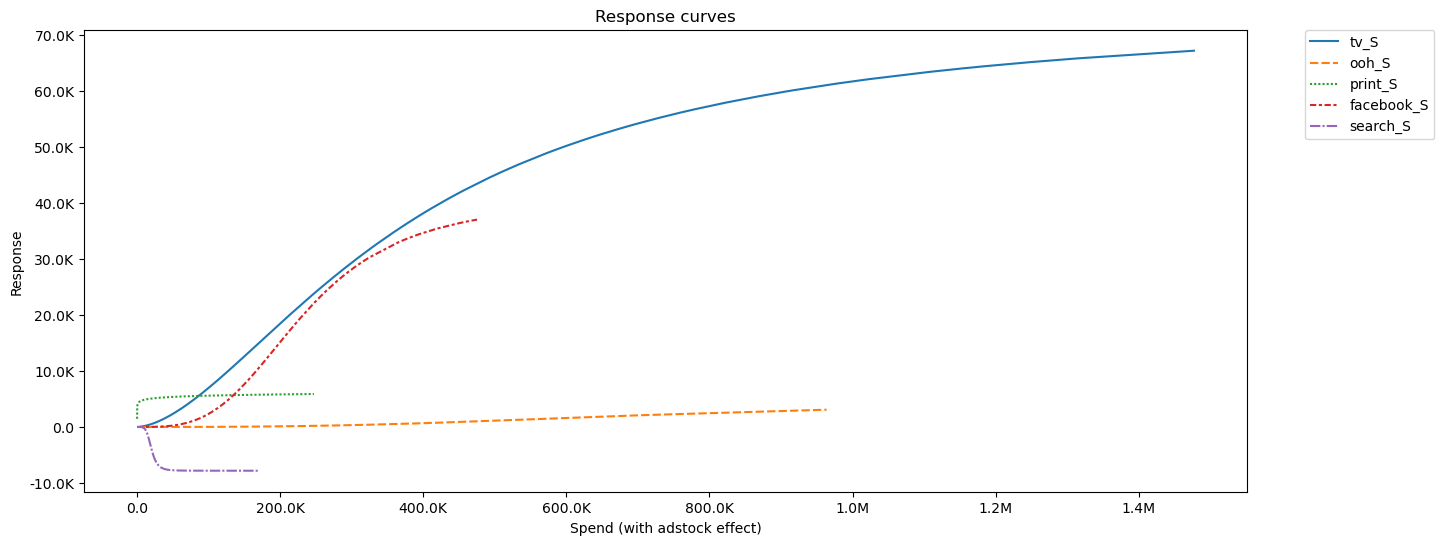

In [22]:
plot_multiple_spend_response_curves(media_spend_response_data)

## Optimize Budget with Saturation Curves

#### Define Boundaries for Optimization

In [23]:
optimization_percentage = 0.2

media_channel_average_spend = result["model_data"][media_channels].mean(axis=0).values

lower_bound = media_channel_average_spend * np.ones(len(media_channels))*(1-optimization_percentage)
upper_bound = media_channel_average_spend * np.ones(len(media_channels))*(1+optimization_percentage)

boundaries = optimize.Bounds(lb=lower_bound, ub=upper_bound)

In [24]:
#### Define Budget Constraint and Saturation Curves

In [25]:
def budget_constraint(media_spend, budget):  
  return np.sum(media_spend) - budget


def saturation_objective_function(coefficients, 
                                  hill_slopes, 
                                  hill_half_saturations, 
                                  media_min_max_dictionary, 
                                  media_inputs):
    
    responses = []
    for i in range(len(coefficients)):
        coef = coefficients[i]
        hill_slope = hill_slopes[i]
        hill_half_saturation = hill_half_saturations[i]
        
        min_max = np.array(media_min_max_dictionary[i])
        media_input = media_inputs[i]
        
        hill_saturation = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).transform(X = min_max, x_point = media_input)
        response = coef * hill_saturation
        responses.append(response)
        
    responses = np.array(responses)
    responses_total = np.sum(responses)
    return -responses_total

#### Define the best parameters for slope and midpoint for optimization

In [26]:
media_coefficients = [feature_coefficients[media_channel] for media_channel in media_channels]
media_hill_slopes = [hill_slopes_params_best[media_channel] for media_channel in media_channels]
media_hill_half_saturations = [hill_half_saturations_params_best[media_channel] for media_channel in media_channels]

#we have to pass min and max of each media channel for proper mapping for saturation hill
media_min_max = [(result["model_data"][f"{media_channel}_adstock"].min(),result["model_data"][f"{media_channel}_adstock"].max())  for media_channel in media_channels]

#### Function to Return Optimized Spend

In [27]:
partial_saturation_objective_function = partial(saturation_objective_function, 
                                                media_coefficients, 
                                                media_hill_slopes, 
                                                media_hill_half_saturations, 
                                                media_min_max)


max_iterations = 100
solver_func_tolerance = 1.0e-10

solution = optimize.minimize(
      fun=partial_saturation_objective_function,
      x0=media_channel_average_spend,
      bounds=boundaries,
      method="SLSQP",
      jac="3-point",
      options={
          "maxiter": max_iterations,
          "disp": True,
          "ftol": solver_func_tolerance,
      },
      constraints={
          "type": "eq",
          "fun": budget_constraint,
          "args": (np.sum(media_channel_average_spend), )
      })


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9319.687565972126
            Iterations: 37
            Function evaluations: 406
            Gradient evaluations: 36


#### Use Solution for Optimized Spend to calculate optimized response and plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tv_S
	tv_S: adstock: 0.6575207519792932
	tv_S: saturation slope: 1.6728929409625368
	tv_S: half saturation k: 0.2599640747807821
	tv_S: coefficient: 74337.84413987651
	average spend: 111327, avergae non-zero spend: 251697, min spend: 0.0, max spend: 1185349.3
	average response corresponding to the average non zero spending: 8210.32339109192
	optimized spend: 133593.22
	optimized response: 10716.38


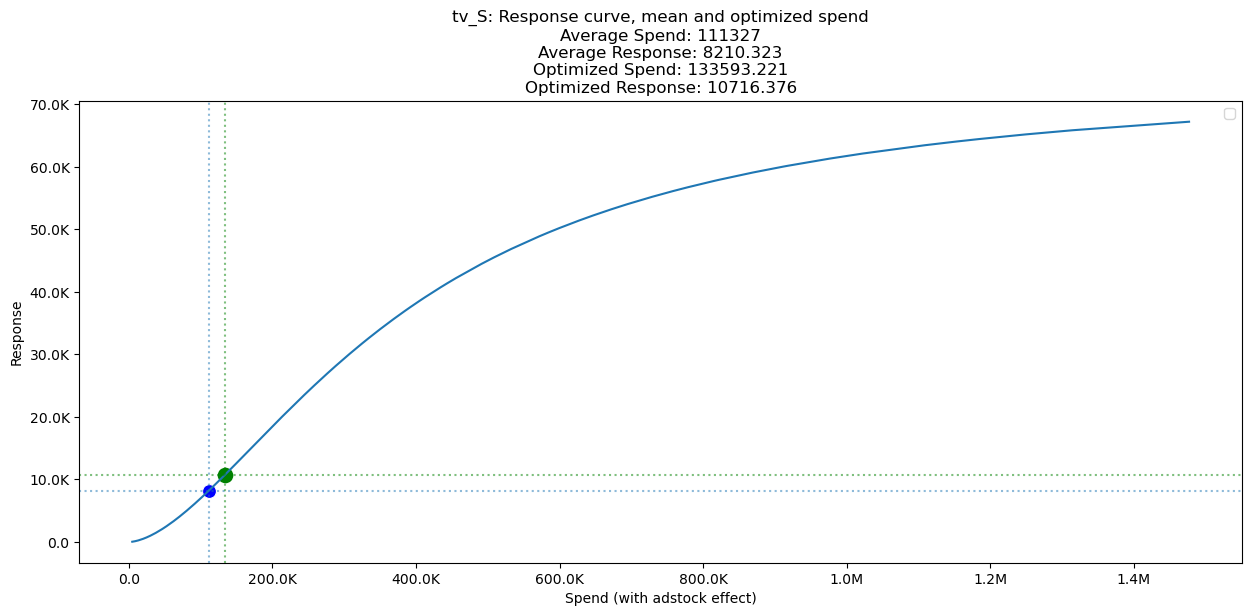

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
ooh_S
	ooh_S: adstock: 0.3996557053973208
	ooh_S: saturation slope: 2.7756460150924323
	ooh_S: half saturation k: 0.7852233074870995
	ooh_S: coefficient: 4661.625691554027
	average spend: 81033, avergae non-zero spend: 198294, min spend: 0, max spend: 938178
	average response corresponding to the average non zero spending: 9.429247506447963
	optimized spend: 64826.91
	optimized response: 5.08


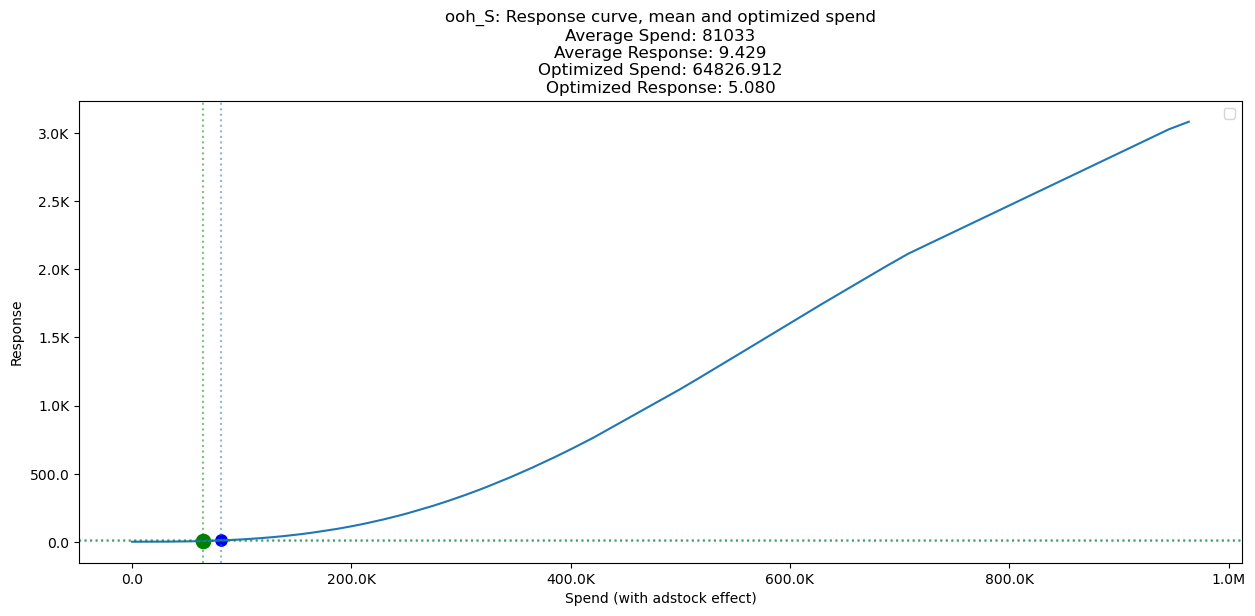

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
print_S
	print_S: adstock: 0.23814492278162178
	print_S: saturation slope: 0.11531762025615766
	print_S: half saturation k: 0.3919568318352354
	print_S: coefficient: 11166.458115462061
	average spend: 27964, avergae non-zero spend: 66858, min spend: 0.0, max spend: 239417.3333
	average response corresponding to the average non zero spending: 5184.052886417075
	optimized spend: 22371.79
	optimized response: 5112.66


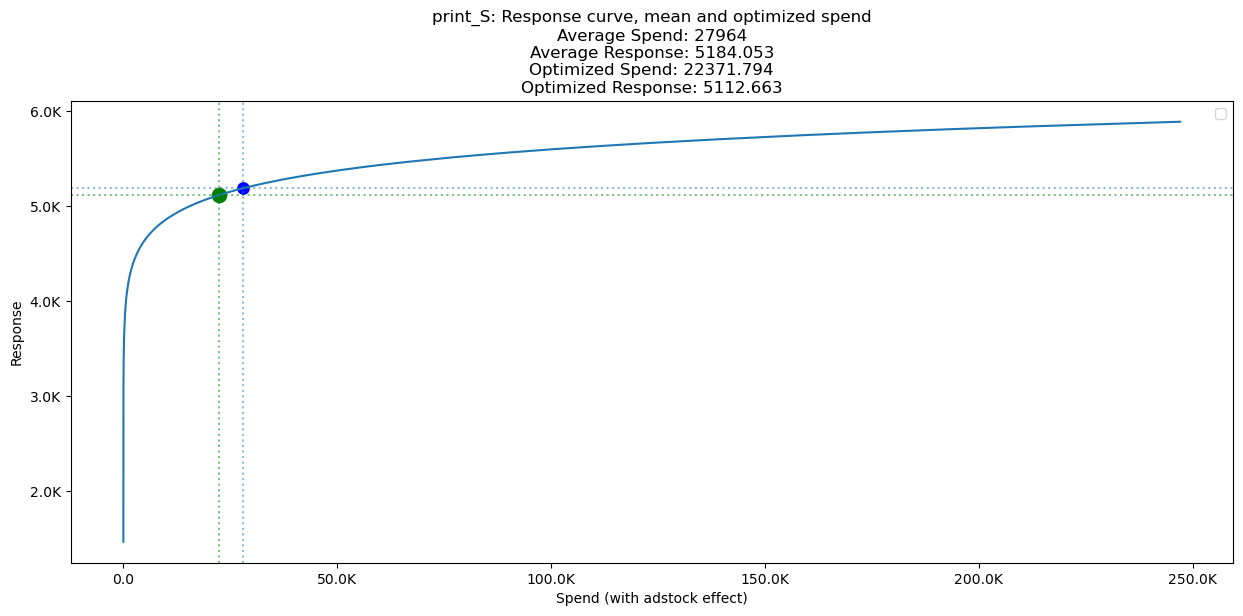

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
facebook_S
	facebook_S: adstock: 0.39221970370858683
	facebook_S: saturation slope: 3.280962284516096
	facebook_S: half saturation k: 0.4931449729532996
	facebook_S: coefficient: 40671.6626109753
	average spend: 64369, avergae non-zero spend: 132563, min spend: 0.0, max spend: 462011.7422
	average response corresponding to the average non zero spending: 577.8651077633942
	optimized spend: 72777.14
	optimized response: 858.44


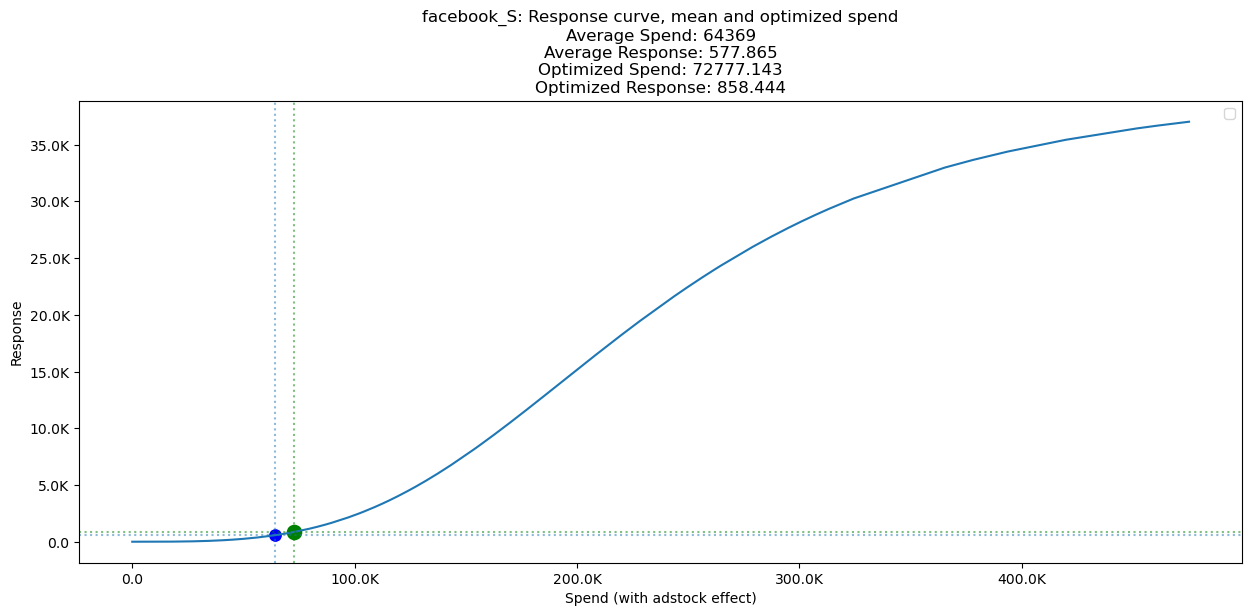

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None
search_S
	search_S: adstock: 0.2356978938632826
	search_S: saturation slope: 4.931945398352253
	search_S: half saturation k: 0.11862922630461825
	search_S: coefficient: -7811.366402723341
	average spend: 44366, avergae non-zero spend: 52432, min spend: 0, max spend: 134100
	average response corresponding to the average non zero spending: -7659.799913949246
	optimized spend: 35493.08
	optimized response: -7372.88


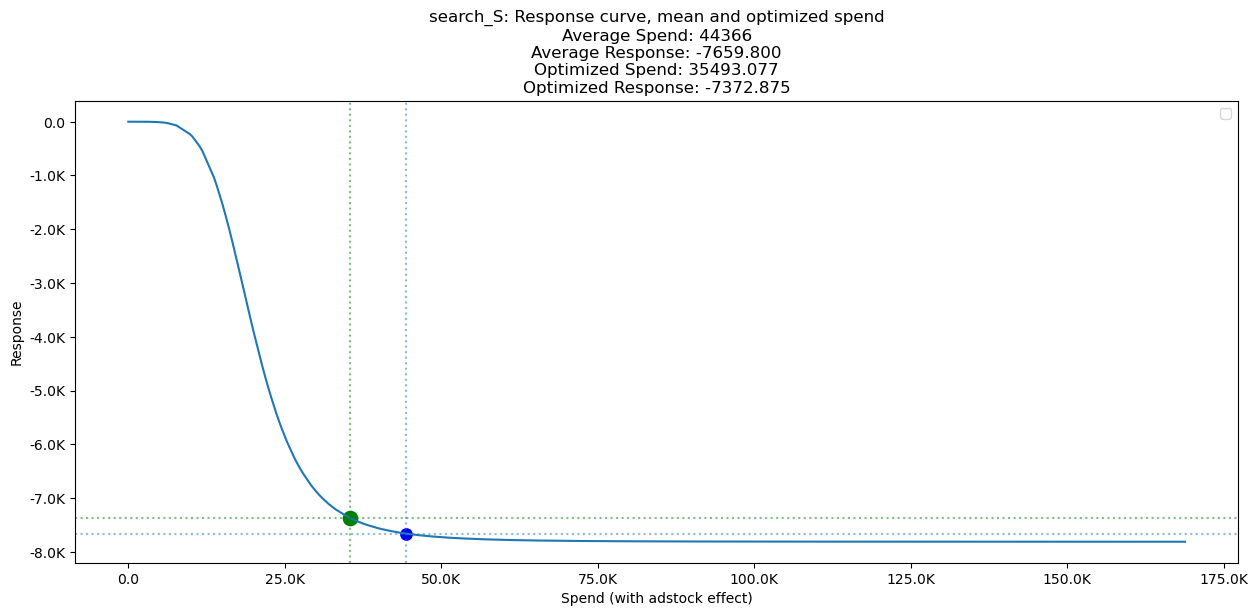

None


In [29]:
#dataframe for budget allocation
budget_allocation_input = pd.DataFrame()

#holds spend and response time series along with average spend/response for plotting spend-response curve
spend_response_curve_dict = {}

#dataframe for budget allocation
media_spend_response_data = []


for i, media_channel in enumerate(media_channels):
    print(media_channel)
    
    adstock = adstock_params_best[media_channel]
    print(f"\t{media_channel}: adstock: {adstock}")

    hill_slope = hill_slopes_params_best[media_channel]
    hill_half_saturation = hill_half_saturations_params_best[media_channel]
    print(f"\t{media_channel}: saturation slope: {hill_slope}")
    print(f"\t{media_channel}: half saturation k: {hill_half_saturation}")

    coef = feature_coefficients[media_channel]
    print(f"\t{media_channel}: coefficient: {coef}")
    ######################################################

    #loc returns end index inclusive
    spendings = result["model_data"][media_channel].values
    average_nonzero_spending = int(spendings[spendings > 0].mean())
    average_spending = int(spendings.mean())
    print(f"\taverage spend: {average_spending}, avergae non-zero spend: {average_nonzero_spending}, min spend: {spendings.min()}, max spend: {spendings.max()}")

    spendings_adstocked = AdstockGeometric(alpha = adstock).fit_transform(spendings)
    
    #we have to use the same data that we used for training for proper mapping of the average spending
    average_response = coef * HillSaturation(slope_s=hill_slope, half_saturation_k=hill_half_saturation).transform(X = spendings_adstocked, x_point = average_spending)
    print(f"\taverage response corresponding to the average non zero spending: {average_response}")

    #numpy array returns end index exclusive
    spendings_saturated = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(spendings_adstocked)
    
    response = spendings_saturated * coef  

    spend_response_temp_df = pd.DataFrame({'spend': spendings_adstocked, 'response': response, "media_channel": media_channel})

    media_spend_response_data.append(spend_response_temp_df)
                                    
    #optimized
    optimized_spend = solution.x[i]
    optimized_response = coef * HillSaturation(slope_s=hill_slope, half_saturation_k=hill_half_saturation).transform(X = spendings_adstocked, x_point = optimized_spend)

    
    print(f"\toptimized spend: {optimized_spend:0.2f}")
    print(f"\toptimized response: {optimized_response:0.2f}")
    
    plot = plot_spend_response_curve(media_channel, 
                                     spend_response_temp_df, 
                                     average_spend = average_spending, 
                                     average_response = average_response, 
                                     optimized_response=optimized_response, 
                                     optimized_spend=optimized_spend)
    print(plot)